In [1]:
import pickle as pkl
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf

2024-03-14 13:31:45.571116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 13:31:45.597381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 13:31:45.597401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 13:31:45.598064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 13:31:45.602093: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 13:31:45.602616: I tensorflow/core/platform/cpu_feature_guard.cc:1

Loading the TN EMOS trained on CRPS

In [3]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

tn = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(tn)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



Loading the validation set

In [4]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(tn.neighbourhood_size, tn.feature_names, test_fold, ignore)
X_test = (X_test - tn.feature_mean) / tn.feature_std

print(X_test.shape)

(7780, 5)


Loading the TN models trained on different weight functions

In [25]:
tn_folder = folder + 'trunc_normal/'

tn_T12 = load_model(tn_folder +'tn_twcrps_threshold12.0.pkl')
tn_T15 = load_model(tn_folder +'tn_twcrps_threshold15.0.pkl')

tn_I_dict = {'tn_T12': tn_T12, 'tn_T15': tn_T15}



Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [26]:
tn_M12_STD4 = load_model(tn_folder + 'tn_twcrps_mean12.0_std4.0.pkl')
tn_M12_STD1 = load_model(tn_folder + 'tn_twcrps_mean12.0_std1.0.pkl')
tn_M15_STD1 = load_model(tn_folder + 'tn_twcrps_mean15.0_std1.0.pkl')
tn_M16_STD5 = load_model(tn_folder + 'tn_twcrps_mean16.0_std5.0.pkl')

tn_CDF_dict = {'tn_M12_STD4': tn_M12_STD4, 'tn_M12_STD1': tn_M12_STD1, 'tn_M15_STD1': tn_M15_STD1, 'tn_M16_STD5': tn_M16_STD5}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


A comparison between the 'standard' truncated normal distribution (which is trained on the CRPS) and the models trained on different scoring rules. As weighted scoring rule the twCRPS is used with different weight functions. 

Possible weight functions:
- the indicator function with a specified threshold (T)
- the CDF of a normal distribution with specified mean and variance (M, STD)

In [27]:
tn_dict = {**tn_I_dict, **tn_CDF_dict}
sample_size = 2000
print("CRPS score for truncated normal: ", tn.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

for key, model in tn_dict.items():
    print(key, "CRPS score: ", model.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

CRPS score for truncated normal:  0.8900658
tn_T12 CRPS score:  0.9142782
tn_T15 CRPS score:  0.9109858
tn_M12_STD4 CRPS score:  0.8977997
tn_M12_STD1 CRPS score:  0.9146947
tn_M15_STD1 CRPS score:  0.91062635
tn_M16_STD5 CRPS score:  0.89988774


There are 7780 values in the PIT diagram


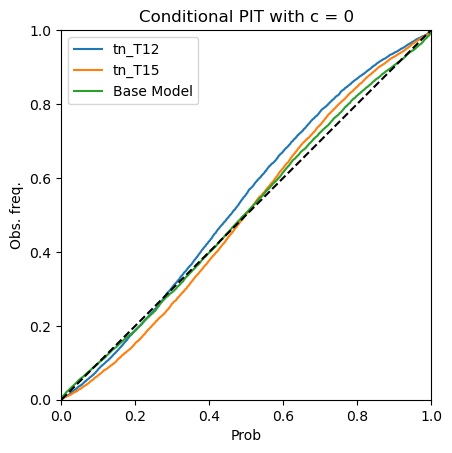

There are 7780 values in the PIT diagram


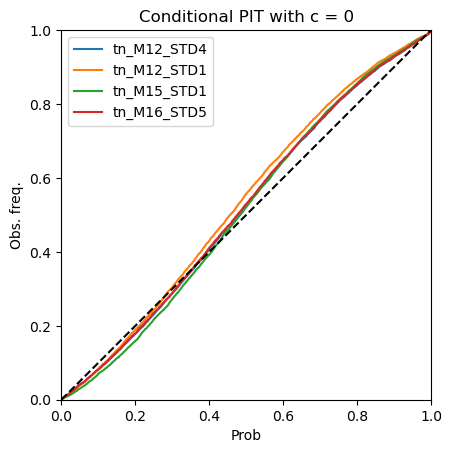

In [28]:
c = 0
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(tn_I_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn)
make_cpit_diagram_emos(tn_CDF_dict, X_test, y_test, variances_test, title=title, t=c)

<font size="5"> Brier skill scores for the different models. As reference model the 'standard' truncated normal distribution is used.</font>

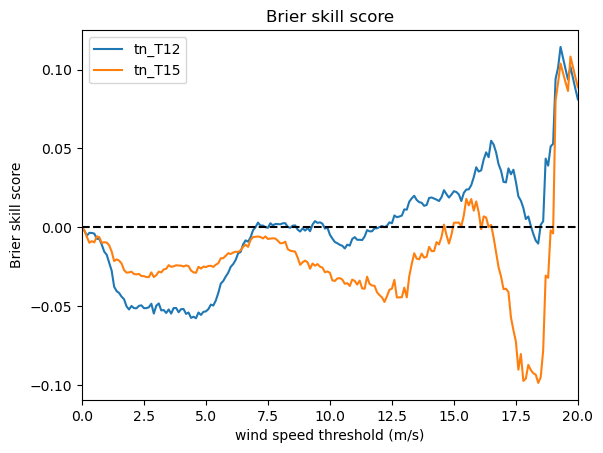

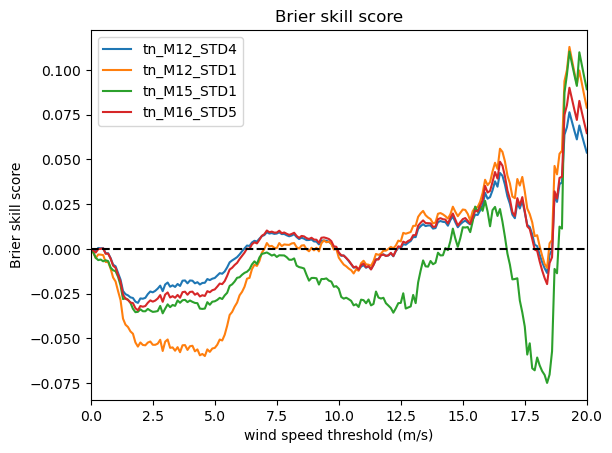

In [31]:
values = np.linspace(0, 20, 201)

brier_skill_plot(tn, tn_I_dict, X_test, y_test, variances_test, values)
brier_skill_plot(tn, tn_CDF_dict, X_test, y_test, variances_test, values)

<font size="5"> Threshold weighted continuously ranked probability scores for different threshold..</font>

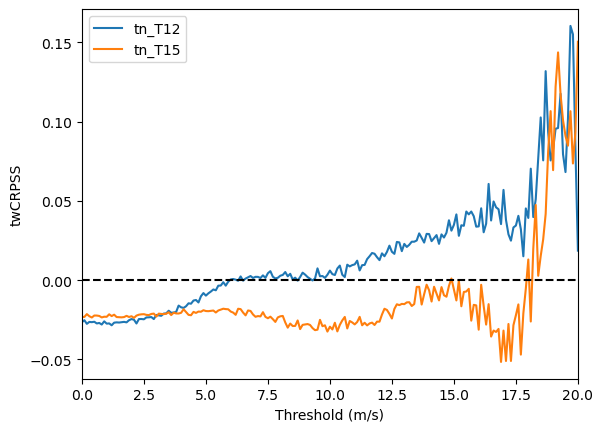

In [29]:
make_twcrpss_plot(tn, tn_I_dict, X_test, y_test, variances_test, values)
make_twcrpss_plot(tn, tn_CDF_dict, X_test, y_test, variances_test, values)

<font size="5"> Reliability diagrams for the models.</front>

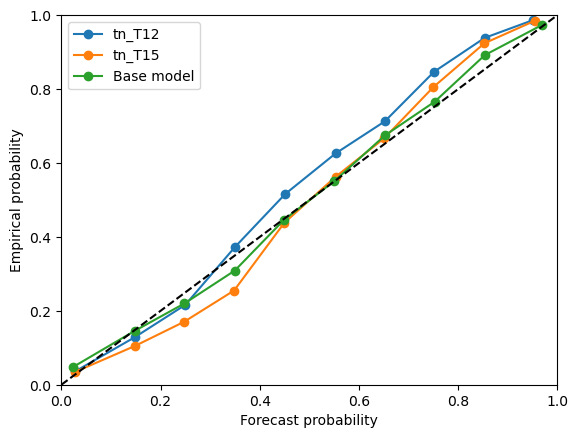

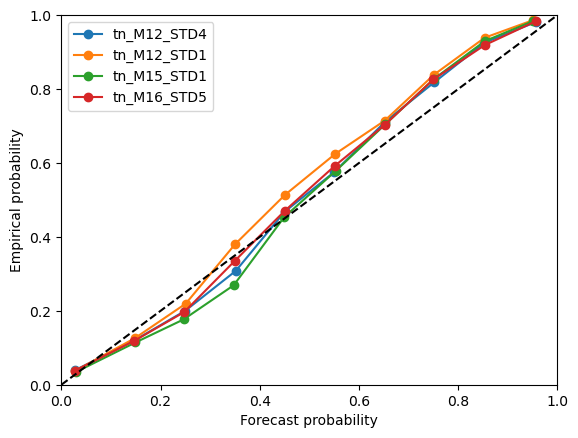

In [33]:
t = 5
make_reliability_diagram(tn_I_dict, X_test, y_test, variances_test, t=t, base_model=tn)
make_reliability_diagram(tn_CDF_dict, X_test, y_test, variances_test, t=t)

In [61]:
gev_folder = folder + 'gev/'

gev = load_model(gev_folder + 'gev_crps_.pkl')

gev_T15 = load_model(gev_folder + 'gev_twcrps_threshold15.0.pkl')
gev_T12 = load_model(gev_folder + 'gev_twcrps_threshold12.0.pkl')

gev_M12_STD4 = load_model(gev_folder + 'gev_twcrps_mean12.0_std4.0.pkl')
gev_M12_STD1 = load_model(gev_folder + 'gev_twcrps_mean12.0_std1.0.pkl')
gev_M16_STD5 = load_model(gev_folder + 'gev_twcrps_mean16.0_std5.0.pkl')

gev_crps_dict = {'gev': gev}
gev_I_dict = {'gev_T12': gev_T12, 'gev_T15': gev_T15}
gev_CDF_dict = {'gev_M12_STD4': gev_M12_STD4, 'gev_M12_STD1': gev_M12_STD1, 'gev_M16_STD5': gev_M16_STD5}

gev_dict = {**gev_I_dict, **gev_CDF_dict, **gev_crps_dict}

Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution


In [63]:
print("Truncated normal CRPS score: ", tn.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())
for key, model in gev_dict.items():
    print(key, "CRPS score: ", model.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

Truncated normal CRPS score:  0.8905619
gev_T12 CRPS score:  1.2319483
gev_T15 CRPS score:  1.2976314
gev_M12_STD4 CRPS score:  0.90130526
gev_M12_STD1 CRPS score:  1.1473806
gev_M16_STD5 CRPS score:  0.9055524
gev CRPS score:  0.8953925


In [64]:
for key, model in gev_dict.items():
    print(key, "Shape parameter: ", model.forecast_distribution.get_gev_shape())

gev_T12 Shape parameter:  [-0.26412857]
gev_T15 Shape parameter:  [-0.21399204]
gev_M12_STD4 Shape parameter:  [-0.22507769]
gev_M12_STD1 Shape parameter:  [-0.26842716]
gev_M16_STD5 Shape parameter:  [-0.23545313]
gev Shape parameter:  [-0.2308029]


There are 7780 values in the PIT diagram


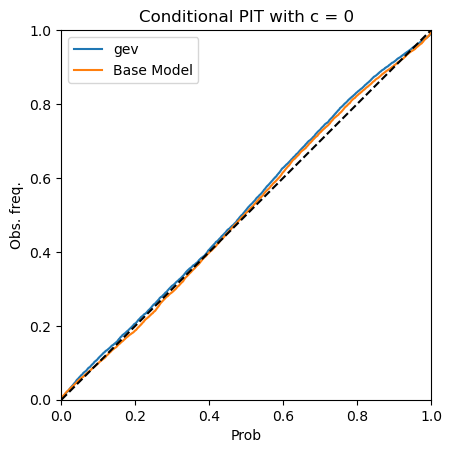

There are 7780 values in the PIT diagram


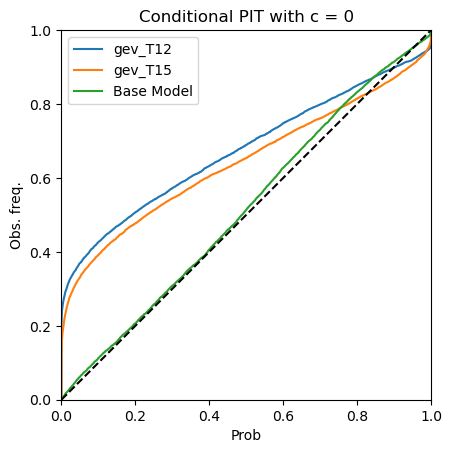

There are 7780 values in the PIT diagram


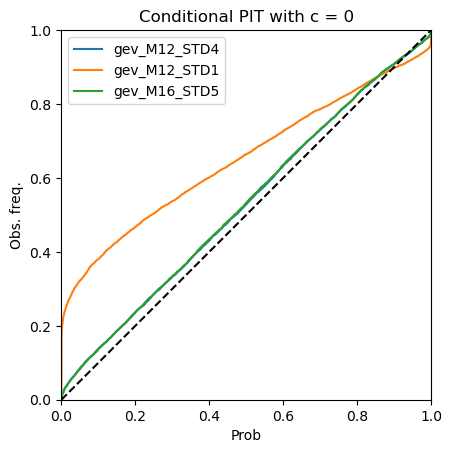

In [66]:
c = 0
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(gev_crps_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn)
make_cpit_diagram_emos(gev_I_dict, X_test, y_test, variances_test, title=title, t=c, base_model=gev)
make_cpit_diagram_emos(gev_CDF_dict, X_test, y_test, variances_test, title=title, t=c)

The models gev_T12 and gev_M12_STD1 large fall outside of the graph due to extremely poor performance.

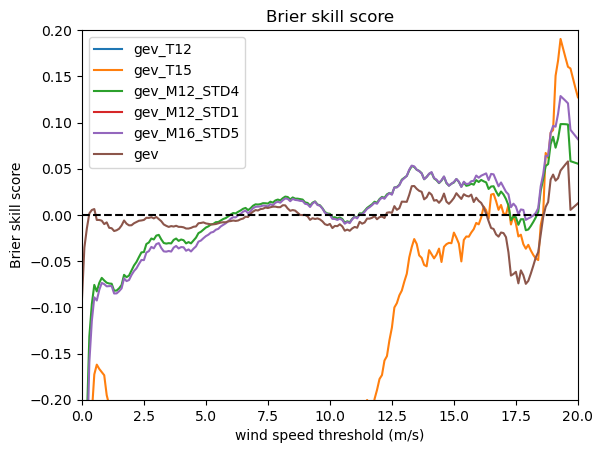

In [72]:
ylim = [-0.2, 0.2]
# ylim = None

brier_skill_plot(tn, gev_dict, X_test, y_test, variances_test, values, ylim=ylim)

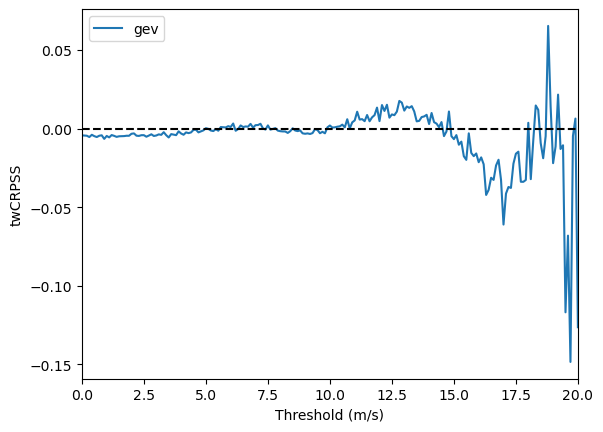

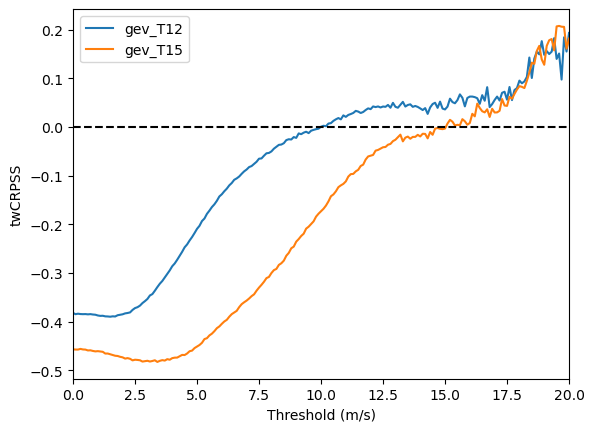

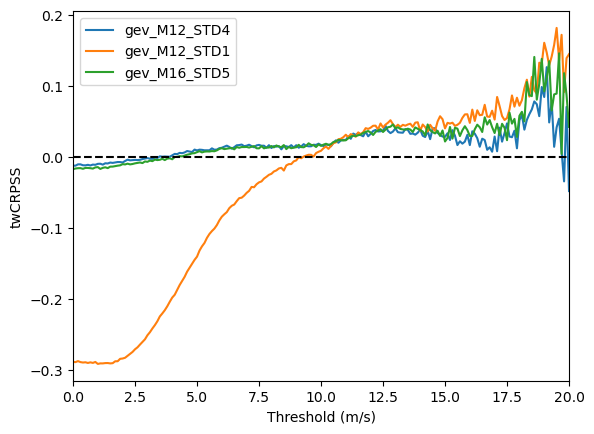

In [73]:
make_twcrpss_plot(tn, gev_crps_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, gev_I_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, gev_CDF_dict, X_test, y_test, variances_test, values, sample_size=1000)

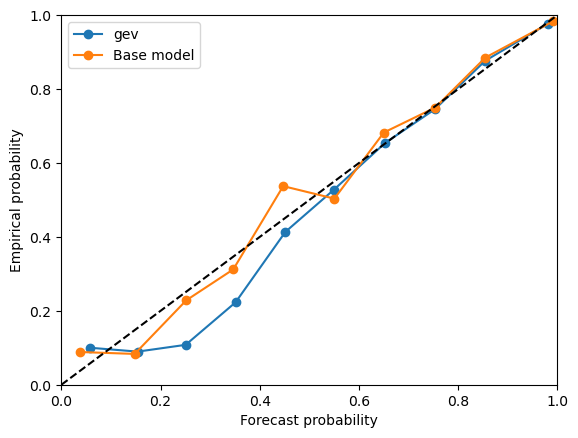

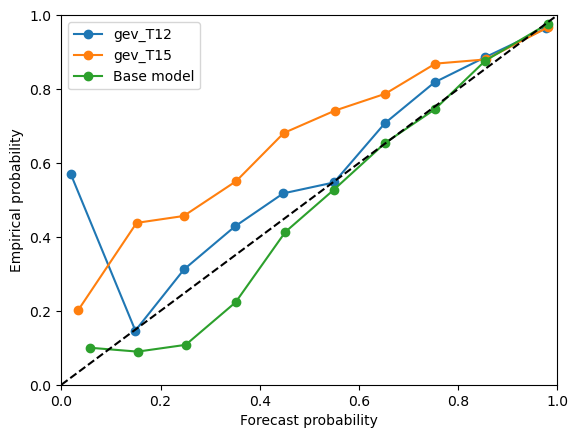

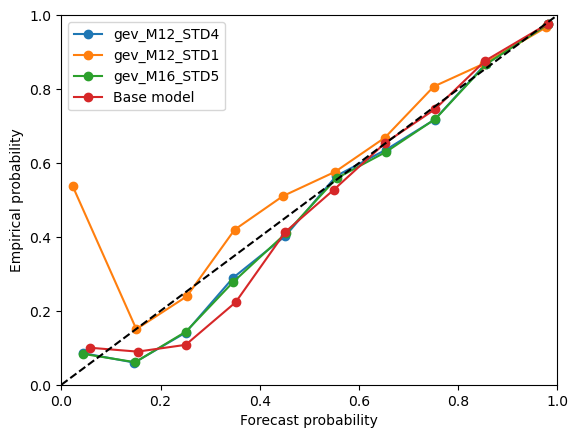

In [74]:
t = 10

make_reliability_diagram(gev_crps_dict, X_test, y_test, variances_test, t=t, base_model=tn)
make_reliability_diagram(gev_I_dict, X_test, y_test, variances_test, t=t, base_model=gev)
make_reliability_diagram(gev_CDF_dict, X_test, y_test, variances_test, t=t, base_model=gev)

In [77]:
frechet_folder = folder + 'frechet/'

frechet = load_model(frechet_folder + 'frechet_crps_.pkl')

frechet_T15 = load_model(frechet_folder + 'frechet_twcrps_threshold15.0.pkl')
frechet_T12 = load_model(frechet_folder + 'frechet_twcrps_threshold12.0.pkl')

frechet_M12_STD4 = load_model(frechet_folder + 'frechet_twcrps_mean12.0_std4.0.pkl')
frechet_M12_STD1 = load_model(frechet_folder + 'frechet_twcrps_mean12.0_std1.0.pkl')
frechet_M16_STD5 = load_model(frechet_folder + 'frechet_twcrps_mean16.0_std5.0.pkl')

frechet_crps_dict = {'frechet': frechet}
frechet_I_dict = {'frechet_T12': frechet_T12, 'frechet_T15': frechet_T15}
frechet_CDF_dict = {'frechet_M12_STD4': frechet_M12_STD4, 'frechet_M12_STD1': frechet_M12_STD1, 'frechet_M16_STD5': frechet_M16_STD5}

frechet_dict = {**frechet_I_dict, **frechet_CDF_dict, **frechet_crps_dict}

Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution


In [78]:
print("Truncated normal CRPS score: ", tn.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())
for key, model in frechet_dict.items():
    print(key, "CRPS score: ", model.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

Truncated normal CRPS score:  0.8910791
frechet_T12 CRPS score:  1.2903013
frechet_T15 CRPS score:  1.4093168
frechet_M12_STD4 CRPS score:  0.9056401
frechet_M12_STD1 CRPS score:  1.169975
frechet_M16_STD5 CRPS score:  0.9097427
frechet CRPS score:  0.89984196


There are 7780 values in the PIT diagram


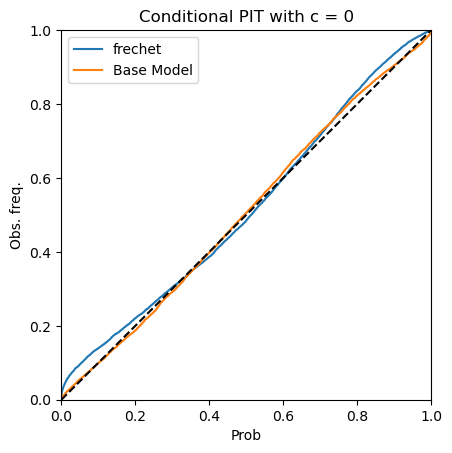

There are 7780 values in the PIT diagram


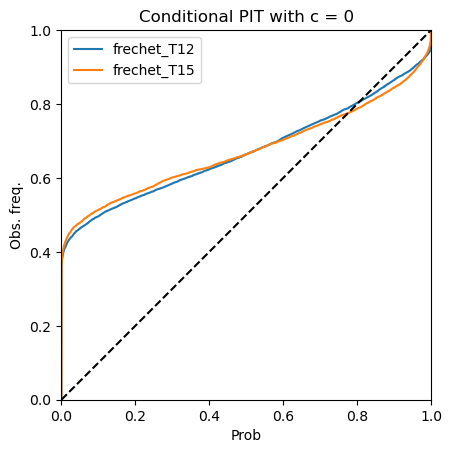

There are 7780 values in the PIT diagram


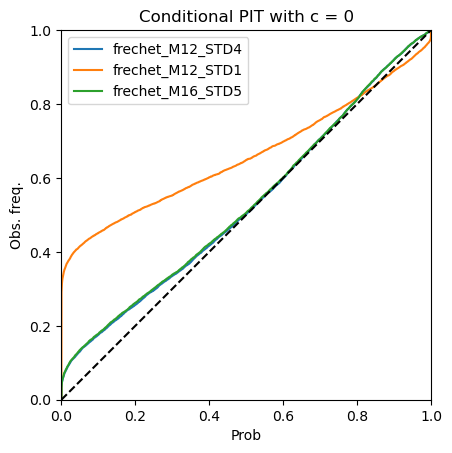

In [81]:
c = 0
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(frechet_crps_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn)
make_cpit_diagram_emos(frechet_I_dict, X_test, y_test, variances_test, title=title, t=c)
make_cpit_diagram_emos(frechet_CDF_dict, X_test, y_test, variances_test, title=title, t=c)

The frechet_T12, frechet_T15 and frechet_M12_STD1 largely fall out of the plot due to extremely poor performance 

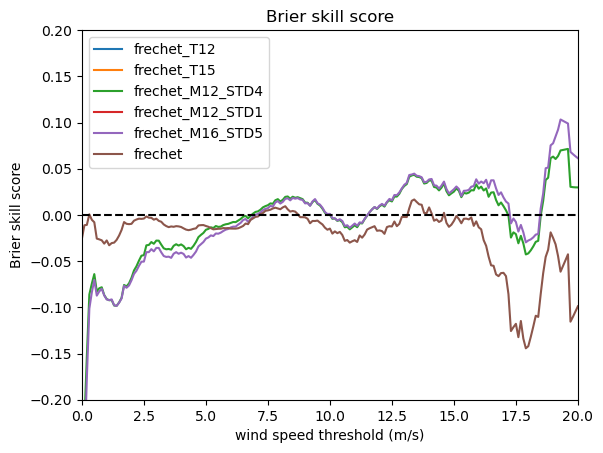

In [85]:
ylim = [-0.2, 0.2]
# ylim = None

brier_skill_plot(tn, frechet_dict, X_test, y_test, variances_test, values, ylim=ylim)

In [ ]:
make_twcrpss_plot(tn, frechet_crps_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, frechet_I_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, frechet_CDF_dict, X_test, y_test, variances_test, values, sample_size=1000)

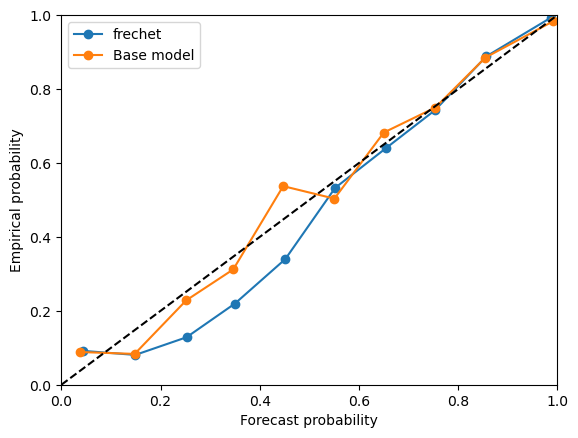

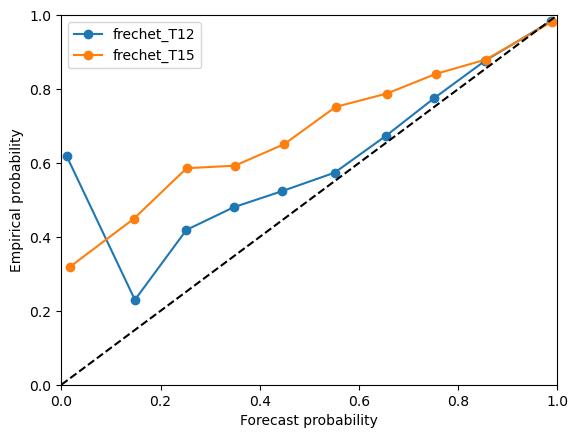

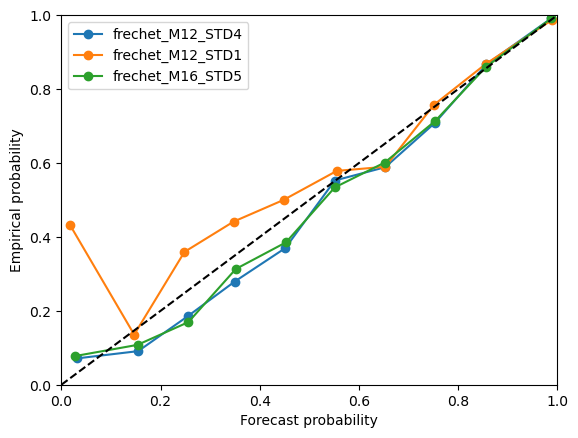

In [86]:
t = 10
make_reliability_diagram(frechet_crps_dict, X_test, y_test, variances_test, t=t, base_model=tn)
make_reliability_diagram(frechet_I_dict, X_test, y_test, variances_test, t=t)
make_reliability_diagram(frechet_CDF_dict, X_test, y_test, variances_test, t=t)

<font size="5">A comparison between models trained on the same (weighted) scoring rule with different probability distributions

We first consider the models trained of cdf of normal distribution with M=12, STD=4

In [98]:
cdf_M12_STD4_dict = {'tn_M12_STD4': tn_M12_STD4, 'gev_M12_STD4': gev_M12_STD4, 'frechet_M12_STD4': frechet_M12_STD4}
tn_M12_STD4 = cdf_M12_STD4_dict.pop('tn_M12_STD4')

In [99]:
print("Truncated normal twCRPS loss with M=12, STD=4: ", tn_M12_STD4.loss(X_test, y_test, variances_test).numpy())
for key, model in cdf_M12_STD4_dict.items():
    print(key, "twCRPS loss: ", model.loss(X_test, y_test, variances_test).numpy())

Truncated normal twCRPS loss with M=12, STD=4:  0.12284863
gev_M12_STD4 twCRPS loss:  0.121566325
frechet_M12_STD4 twCRPS loss:  0.122482255


There are 848 values in the PIT diagram


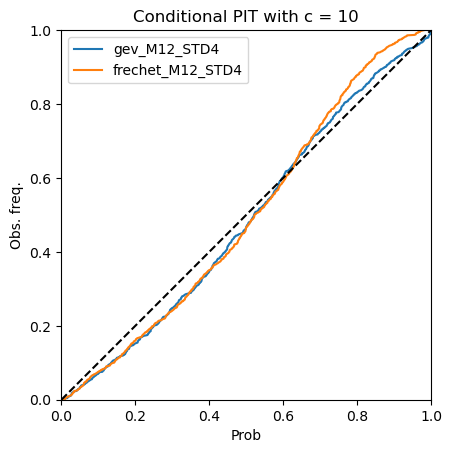

In [88]:
c = 10
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(cdf_M12_STD4_dict, X_test, y_test, variances_test, title=title, t=c)

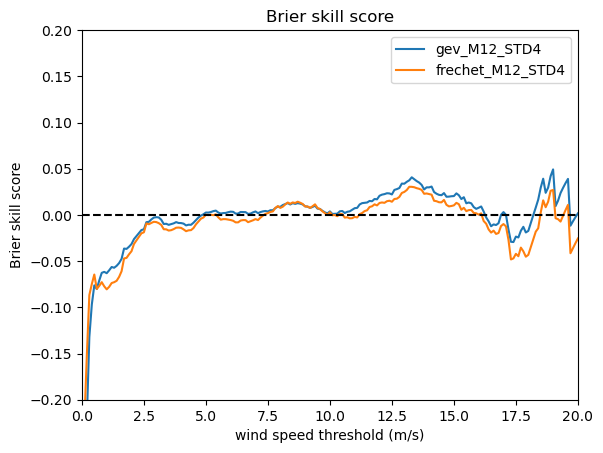

In [101]:
brier_skill_plot(tn_M12_STD4, cdf_M12_STD4_dict, X_test, y_test, variances_test, values, ylim=ylim)

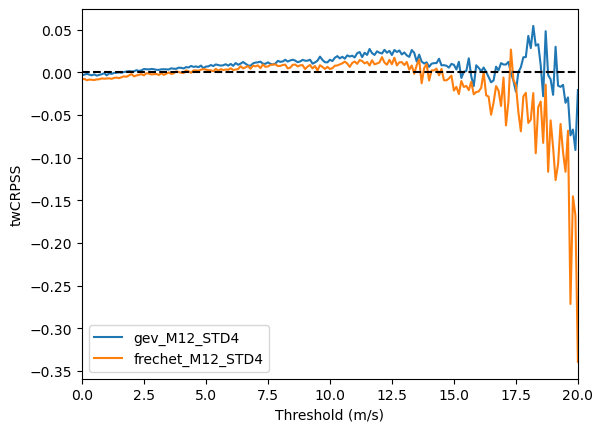

In [90]:
make_twcrpss_plot(tn_M12_STD4, cdf_M12_STD4_dict, X_test, y_test, variances_test, values, sample_size=1000)

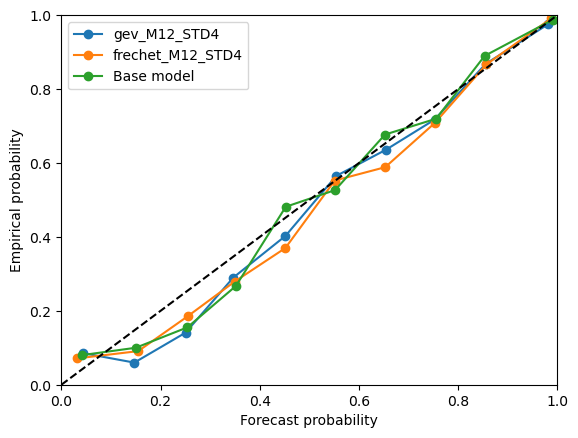

In [102]:
t = 10
make_reliability_diagram(cdf_M12_STD4_dict, X_test, y_test, variances_test, t=t, base_model=tn_M12_STD1)

In [94]:
cdf_M16_STD5_dict = {'tn_M16_STD5': tn_M16_STD5, 'gev_M16_STD5': gev_M16_STD5, 'frechet_M16_STD5': frechet_M16_STD5}

tn_M16_STD5 = cdf_M16_STD5_dict.pop('tn_M16_STD5')

In [95]:
print("Truncated normal twCRPS loss with M=16, STD=5: ", tn_M16_STD5.loss(X_test, y_test, variances_test).numpy())
for key, model in cdf_M16_STD5_dict.items():
    print(key, "twCRPS loss: ", model.loss(X_test, y_test, variances_test).numpy())

Truncated normal twCRPS loss with M=16, STD=5:  0.051561058
gev_M16_STD5 twCRPS loss:  0.050974857
frechet_M16_STD5 twCRPS loss:  0.0512554


There are 848 values in the PIT diagram


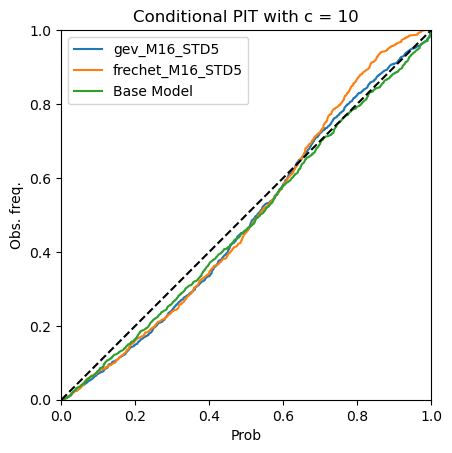

In [103]:
make_cpit_diagram_emos(cdf_M16_STD5_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn_M16_STD5)

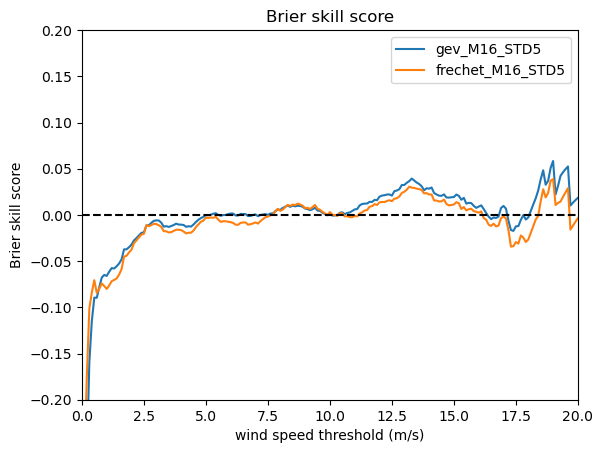

In [97]:
brier_skill_plot(tn_M16_STD5, cdf_M16_STD5_dict, X_test, y_test, variances_test, values, ylim=ylim)

In [ ]:
make_twcrpss_plot(tn_M16_STD5, cdf_M16_STD5_dict, X_test, y_test, variances_test, values, sample_size=1000)

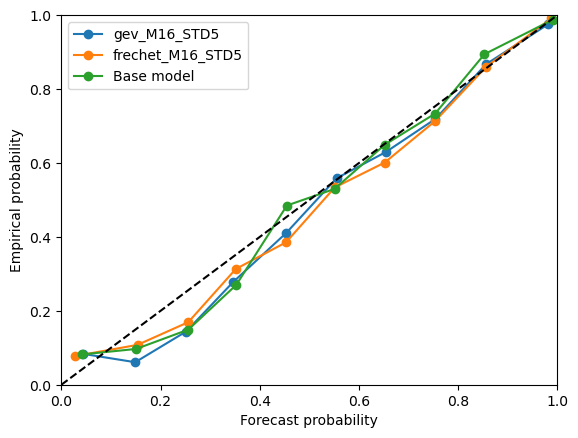

In [104]:
make_reliability_diagram(cdf_M16_STD5_dict, X_test, y_test, variances_test, t=t, base_model=tn_M16_STD5)